<a href="https://colab.research.google.com/github/Singular-Brain/DeepBioLCNet/blob/main/BioLCNet_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setups

In [1]:
!pip install -q git+https://github.com/Singular-Brain/DeepBioLCNet


In [2]:
!git clone https://github.com/Singular-Brain/DeepBioLCNet


fatal: destination path 'DeepBioLCNet' already exists and is not an empty directory.


In [3]:
### gym and colab compatibility

!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import count
from matplotlib.axes import Axes
from matplotlib.image import AxesImage
from torch.nn.modules.utils import _pair
from matplotlib.collections import PathCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Tuple, List, Optional, Sized, Dict, Union
import math
import random
from torchvision.transforms.functional import crop
# from ..utils import reshape_locally_connected_weights, reshape_locally_connected_weights_meh, reshape_conv2d_weights

import gym
import tkinter

from PIL import Image
from collections import namedtuple

In [5]:
from bindsnet.network.nodes import Nodes
import os
### import torch
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import collections
from torchvision import transforms
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch.nn.functional as fn

from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes, IFNodes
from bindsnet.network.topology import Connection, MaxPool2dLocalConnection
from bindsnet.network.topology import LocalConnection, LocalConnectionOrig
from bindsnet.network.monitors import Monitor, AbstractMonitor, TensorBoardMonitor
from bindsnet.learning import PostPre, MSTDP, MSTDPET, WeightDependentPostPre, Hebbian
from bindsnet.learning.reward import DynamicDopamineInjection, DopaminergicRPE, RLTasks
from bindsnet.analysis.plotting import plot_locally_connected_weights,plot_locally_connected_weights_meh,plot_spikes,\
plot_LC_timepoint_spikes,plot_locally_connected_weights_meh2,plot_convergence_and_histogram,plot_locally_connected_weights_meh3
from bindsnet.analysis.visualization import plot_weights_movie, plot_spike_trains_for_example,summary, plot_voltage
from bindsnet.utils import reshape_locally_connected_weights, reshape_locally_connected_weights_meh, reshape_conv2d_weights

## Sets up Gpu use and manual seed


In [6]:
if torch.cuda.is_available():
    device =  torch.device("cuda")
    gpu = True
else:
    device =  torch.device("cpu")
    gpu = False

def manual_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


SEED = 2045 # The Singularity is Near!
manual_seed(SEED)
WANDB = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)


Running on Device =  cuda


# Custom Monitors

## Reward Monitor

In [7]:
class RewardMonitor(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        time: None,
        batch_size: int = 1,
        device: str = "cpu",
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()

        self.time = time
        self.batch_size = batch_size
        self.device = device

        # if time is not specified the monitor variable accumulate the logs
        if self.time is None:
            self.device = "cpu"

        self.recording = []
        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if "reward" in kwargs:
            self.recording.append(kwargs["reward"])
        # remove the oldest element (first in the list)
        # if self.time is not None:
        #     self.recording.pop(0)

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = []


## Plot Eligibility trace

In [8]:
class PlotET(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        i,
        j,
        source,
        target,
        connection,
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()
        self.i = i
        self.j = j
        self.source = source
        self.target = target
        self.connection = connection

        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if hasattr(self.connection.update_rule, 'p_plus'):
            self.recording['spikes_i'].append(self.source.s.ravel()[self.i].item())
            self.recording['spikes_j'].append(self.target.s.ravel()[self.j].item())
            self.recording['p_plus'].append(self.connection.update_rule.p_plus[self.i].item())
            self.recording['p_minus'].append(self.connection.update_rule.p_minus[self.j].item())
            self.recording['eligibility'].append(self.connection.update_rule.eligibility[self.i,self.j].item())
            self.recording['eligibility_trace'].append(self.connection.update_rule.eligibility_trace[self.i,self.j].item())
            self.recording['w'].append(self.connection.w[self.i,self.j].item())

    def plot(self):

        fig, axs  = plt.subplots(7)
        fig.set_size_inches(10, 20)
        for i, (name, p) in enumerate(self.recording.items()):
            axs[i].plot(p[-250:])
            axs[i].set_title(name)
    
        fig.show()

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = {
        'spikes_i': [],
        'spikes_j': [],
        'p_plus':[],
        'p_minus':[],
        'eligibility':[],
        'eligibility_trace':[],
        'w': [],
        }


## Kernel 

In [9]:
class AbstractKernel(ABC):
    def __init__(self, kernel_size):
        """
        Base class for generating image filter kernels such as Gabor, DoG, etc. Each subclass should override :attr:`__call__` function.
        Instantiates a ``Filter Kernel`` object.
        :param window_size : The size of the kernel (int)
        """
        self.window_size = kernel_size

    def __call__(self):
        pass


In [10]:
class DoGKernel(AbstractKernel):
    def __init__(self, kernel_size: Union[int, Tuple[int, int]], sigma1 : float, sigma2 : float):
        """
        Generates DoG filter kernels.
        :param kernel_size: Horizontal and vertical size of DOG kernels.(If pass int, we consider it as a square filter) 
        :param sigma1 : The sigma parameter for the first Gaussian function.
        :param sigma2 : The sigma parameter for the second Gaussian function.
        """
        super(DoGKernel, self).__init__(kernel_size)
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        
    def __call__(self):
        k = self.window_size//2
        x, y = np.mgrid[-k:k+1:1, -k:k+1:1]
        a = 1.0 / (2 * math.pi)
        prod = x*x + y*y
        f1 = (1/(self.sigma1*self.sigma1)) * np.exp(-0.5 * (1/(self.sigma1*self.sigma1)) * (prod))
        f2 = (1/(self.sigma2*self.sigma2)) * np.exp(-0.5 * (1/(self.sigma2*self.sigma2)) * (prod))
        dog = a * (f1-f2)
        dog_mean = np.mean(dog)
        dog = dog - dog_mean
        dog_max = np.max(dog)
        dog = dog / dog_max
        dog_tensor = torch.from_numpy(dog)
        # returns a 2d tensor corresponding to the requested DoG filter
        return dog_tensor.float()

In [11]:
class Filter():
    """
    Applies a filter transform. Each filter contains a sequence of :attr:`FilterKernel` objects.
    The result of each filter kernel will be passed through a given threshold (if not :attr:`None`).
    Args:
        filter_kernels (sequence of FilterKernels): The sequence of filter kernels.
        padding (int, optional): The size of the padding for the convolution of filter kernels. Default: 0
        thresholds (sequence of floats, optional): The threshold for each filter kernel. Default: None
        use_abs (boolean, optional): To compute the absolute value of the outputs or not. Default: False
    .. note::
        The size of the compund filter kernel tensor (stack of individual filter kernels) will be equal to the 
        greatest window size among kernels. All other smaller kernels will be zero-padded with an appropriate 
        amount.
    """
    # filter_kernels must be a list of filter kernels
    # thresholds must be a list of thresholds for each kernel
    def __init__(self, filter_kernels, padding=0, thresholds=None, use_abs=False):
        tensor_list = []
        self.max_window_size = 0
        for kernel in filter_kernels:
            if isinstance(kernel, torch.Tensor):
                tensor_list.append(kernel)
                self.max_window_size = max(self.max_window_size, kernel.size(-1))
            else:
                tensor_list.append(kernel().unsqueeze(0))
                self.max_window_size = max(self.max_window_size, kernel.window_size)
        for i in range(len(tensor_list)):
            p = (self.max_window_size - filter_kernels[i].window_size)//2
            tensor_list[i] = fn.pad(tensor_list[i], (p,p,p,p))

        self.kernels = torch.stack(tensor_list)
        self.number_of_kernels = len(filter_kernels)
        self.padding = padding
        if isinstance(thresholds, list):
            self.thresholds = thresholds.clone().detach()
            self.thresholds.unsqueeze_(0).unsqueeze_(2).unsqueeze_(3)
        else:
            self.thresholds = thresholds
        self.use_abs = use_abs

    # returns a 4d tensor containing the flitered versions of the input image
    # input is a 4d tensor. dim: (minibatch=1, filter_kernels, height, width)
    def __call__(self, input):

        # if input.dim() == 3:
        #     input2 = torch.unsqueeze(input, 0)
        input.unsqueeze_(0)
        output = fn.conv2d(input, self.kernels, padding = self.padding).float()
        if not(self.thresholds is None):
            output = torch.where(output < self.thresholds, torch.tensor(0.0, device=output.device), output)
        if self.use_abs:
            torch.abs_(output)
        return output.squeeze(0)

# Viz

In [12]:
def plot_LC_timepoint_spikes(spikes: torch.Tensor,
    timepoint: int,
    n_filters: int,
    in_chans: int,
    slice_to_plot: int,
    conv_size: Union[int, Tuple[int, int]],
    im: Optional[AxesImage] = None,
    lines: bool = True,
    figsize: Tuple[int, int] = (10, 10),
    cmap: str = "hot_r",
    color: str='r'
    ):
    # language=rst
    """
    """

    n_sqrt = int(np.ceil(np.sqrt(n_filters)))
    sel_slice = spikes[timepoint].view(in_chans, n_filters, conv_size, conv_size).cpu()
    sel_slice = sel_slice[slice_to_plot, ...].view(n_filters, conv_size, conv_size)
    spikes_ = np.zeros((n_sqrt*conv_size, n_sqrt*conv_size))
    filt_counter = 0

    fig, ax = plt.subplots(figsize=figsize)

    for n1 in range(n_sqrt):
        for n2 in range(n_sqrt):
            filter_ = sel_slice[filt_counter, :, :].view(conv_size, conv_size)
            spikes_[n1 * conv_size : (n1 + 1) * conv_size, n2 * conv_size : (n2 + 1) * conv_size] = filter_
            filt_counter += 1
            ax.axhline((n1 + 1) * conv_size, color="g", linestyle="-")
            ax.axvline((n2 + 1) * conv_size, color="g", linestyle="--")
    ax.imshow(spikes_, cmap='Greys')
    return spikes_
    
def plot_FC_response_map(lc: object,
    fc: object,
    ind_neuron_in_group: int,
    label: int,
    n_per_action: int,
    input_channel: int = 0,
    scale_factor: float = 1.0,
    lines: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    cmap: str = "hot_r",
    color: str='r'
    ) -> AxesImage:
    # language=rst
    """
    Plot a connection weight matrix of a :code:`Connection` with `locally connected
    structure <http://yann.lecun.com/exdb/publis/pdf/gregor-nips-11.pdf>_.
    :param lc: LC connection object of LCNet
    :param fc: FC connection object of LCNet
    :param input_channel: indicates weights which connected to this channel of input
    :param scale_factor: determines intensity of activation map  
    :param lines: Whether or not to draw horizontal and vertical lines separating input regions.
    :param figsize: Horizontal, vertical figure size in inches.
    :param cmap: Matplotlib colormap.
    :return: Used for re-drawing the weights plot.
    """

    n_sqrt = int(np.ceil(np.sqrt(lc.out_channels)))

    sel_slice = lc.w.view(lc.in_channels, lc.out_channels, lc.conv_size[0], lc.conv_size[1], lc.kernel_size[0], lc.kernel_size[1]).cpu()
    sel_slice = sel_slice[input_channel, ...]
    input_size = _pair(int(np.sqrt(lc.source.n)))
    reshaped = reshape_LC_weights(sel_slice, lc.out_channels, lc.kernel_size, lc.conv_size, input_size)
	
    ind_neuron = label * n_per_action + ind_neuron_in_group
    w = fc.w[:,ind_neuron].view(reshaped.shape[0]//lc.kernel_size[0],reshaped.shape[1]//lc.kernel_size[1])
    w = w.clip(lc.wmin,lc.wmax).repeat_interleave(lc.kernel_size[0], dim=0).repeat_interleave(lc.kernel_size[1], dim=1).cpu()

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(reshaped.cpu()*w, cmap=cmap, vmin=lc.wmin, vmax=lc.wmax)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.05)

    if lines:
        for i in range(
            n_sqrt * lc.kernel_size[0],
            n_sqrt * lc.conv_size[0] * lc.kernel_size[0],
            n_sqrt * lc.kernel_size[0],
        ):
            ax.axhline(i - 0.5, color=color, linestyle="--")

        for i in range(
            n_sqrt * lc.kernel_size[1],
            n_sqrt * lc.conv_size[1] * lc.kernel_size[1],
            n_sqrt * lc.kernel_size[1],
        ):
            ax.axvline(i - 0.5, color=color, linestyle="--")

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("auto")

    plt.colorbar(im, cax=cax)
    fig.tight_layout()

    return im

def plot_LC_activation_map(lc : object,
    spikes: torch.tensor,
    input_channel: int = 0,
    scale_factor: float = 1.0,
    lines: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    cmap: str = "hot_r",
    color: str='r'
    ) -> AxesImage:
    # language=rst
    """
    Plot an activation map of a :code:`Connection` with `locally connected
    structure <http://yann.lecun.com/exdb/publis/pdf/gregor-nips-11.pdf>_.
    :param lc: LC connection object of LCNet
    :param input_channel: indicates weights which connected to this channel of input 
    :param scale_factor: determines intensity of activation map 
    :param lines: Whether or not to draw horizontal and vertical lines separating input regions.
    :param figsize: Horizontal, vertical figure size in inches.
    :param cmap: Matplotlib colormap.
    :return: Used for re-drawing the weights plot.
    """
    spikes = spikes.sum(0).squeeze().view(lc.conv_size[0]*int(np.sqrt(lc.out_channels)),lc.conv_size[1]*int(np.sqrt(lc.out_channels)))
    x = scale_factor * spikes / torch.max(spikes)
    x = x.clip(lc.wmin,lc.wmax).repeat_interleave(lc.kernel_size[0], dim=0).repeat_interleave(lc.kernel_size[1], dim=1).cpu()
    n_sqrt = int(np.ceil(np.sqrt(lc.out_channels)))

    sel_slice = lc.w.view(lc.in_channels, lc.out_channels, lc.conv_size[0], lc.conv_size[1], lc.kernel_size[0], lc.kernel_size[1]).cpu()
    sel_slice = sel_slice[input_channel, ...]
    input_size = _pair(int(np.sqrt(lc.source.n)))
    reshaped = reshape_LC_weights(sel_slice, lc.out_channels, lc.kernel_size, lc.conv_size, input_size)

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(reshaped.cpu()*x, cmap=cmap, vmin=lc.wmin, vmax=lc.wmax)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.05)

    if lines:
        for i in range(
            n_sqrt * lc.kernel_size[0],
            n_sqrt * lc.conv_size[0] * lc.kernel_size[0],
            n_sqrt * lc.kernel_size[0],
        ):
            ax.axhline(i - 0.5, color=color, linestyle="--")

        for i in range(
            n_sqrt * lc.kernel_size[1],
            n_sqrt * lc.conv_size[1] * lc.kernel_size[1],
            n_sqrt * lc.kernel_size[1],
        ):
            ax.axvline(i - 0.5, color=color, linestyle="--")

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("auto")

    plt.colorbar(im, cax=cax)
    fig.tight_layout()

    return im


def reshape_LC_weights(
    w: torch.Tensor,
    n_filters: int,
    kernel_size: Union[int, Tuple[int, int]],
    conv_size: Union[int, Tuple[int, int]],
    input_sqrt: Union[int, Tuple[int, int]],
) -> torch.Tensor:
    # language=rst
    """
    Get the weights from a locally connected layer and reshape them to be two-dimensional and square.
    :param w: Weights from a locally connected layer.
    :param n_filters: No. of neuron filters.
    :param kernel_size: Side length(s) of convolutional kernel.
    :param conv_size: Side length(s) of convolution population.
    :param input_sqrt: Sides length(s) of input neurons.
    :return: Locally connected weights reshaped as a collection of spatially ordered square grids.
    """
    k1, k2 = kernel_size
    c1, c2 = conv_size
    i1, i2 = input_sqrt
    c1sqrt, c2sqrt = int(math.ceil(math.sqrt(c1))), int(math.ceil(math.sqrt(c2)))
    fs = int(math.ceil(math.sqrt(n_filters)))

    w_ = torch.zeros((n_filters * k1, k2 * c1 * c2))

    for n1 in range(c1):
        for n2 in range(c2):
            for feature in range(n_filters):
                n = n1 * c2 + n2
                filter_ = w[feature, n1, n2, :, :
                ].view(k1, k2)
                w_[feature * k1 : (feature + 1) * k1, n * k2 : (n + 1) * k2] = filter_

    if c1 == 1 and c2 == 1:
        square = torch.zeros((i1 * fs, i2 * fs))

        for n in range(n_filters):
            square[
                (n // fs) * i1 : ((n // fs) + 1) * i2,
                (n % fs) * i2 : ((n % fs) + 1) * i2,
            ] = w_[n * i1 : (n + 1) * i2]

        return square
    else:
        square = torch.zeros((k1 * fs * c1, k2 * fs * c2))

        for n1 in range(c1):
            for n2 in range(c2):
                for f1 in range(fs):
                    for f2 in range(fs):
                        if f1 * fs + f2 < n_filters:
                            square[
                                k1 * (n1 * fs + f1) : k1 * (n1 * fs + f1 + 1),
                                k2 * (n2 * fs + f2) : k2 * (n2 * fs + f2 + 1),
                            ] = w_[
                                (f1 * fs + f2) * k1 : (f1 * fs + f2 + 1) * k1,
                                (n1 * c2 + n2) * k2 : (n1 * c2 + n2 + 1) * k2,
                            ]

        return square

def plot_semantic_pooling(lc : object,
    input_channel: int = 0,
    output_channel: int = None,
    lines: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    cmap: str = "hot_r",
    color: str='r',
    ) -> AxesImage:
    # language=rst
    """
    Plot a connection weight matrix of a :code:`Connection` with `locally connected
    structure <http://yann.lecun.com/exdb/publis/pdf/gregor-nips-11.pdf>_.
    :param lc: LC connection object of LCNet
    :param input_channel: indicates weights which connected to this channel of input 
    :param output_channel: indicates weights of specific channel in the output layer
    :param lines: Whether or not to draw horizontal and vertical lines separating input regions.
    :param figsize: Horizontal, vertical figure size in inches.
    :param cmap: Matplotlib colormap.
    :return: Used for re-drawing the weights plot.
    """

    n_sqrt = int(np.ceil(np.sqrt(lc.out_channels)))
    sel_slice = lc.w.view(lc.in_channels, lc.out_channels, lc.conv_size[0], lc.conv_size[1], lc.kernel_size[0], lc.kernel_size[1]).cpu()
    input_size = _pair(int(np.sqrt(lc.source.n)))
    
    if output_channel is None:
        sel_slice = sel_slice[input_channel, ...]
        reshaped = reshape_LC_weights(sel_slice, lc.out_channels, lc.kernel_size, lc.conv_size, input_size)
    else:
        sel_slice = sel_slice[input_channel, output_channel, ...]
        sel_slice = sel_slice.unsqueeze(0)
        reshaped = reshape_LC_weights(sel_slice, 1, lc.kernel_size, lc.conv_size, input_size)
        print(reshaped.shape)

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(reshaped.cpu(), cmap=cmap, vmin=lc.wmin, vmax=lc.wmax)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.05)

    if lines and  output_channel is None:
        for i in range(
            n_sqrt * lc.kernel_size[0],
            n_sqrt * lc.conv_size[0] * lc.kernel_size[0],
            n_sqrt * lc.kernel_size[0],
        ):
            ax.axhline(i - 0.5, color=color, linestyle="--")

        for i in range(
            n_sqrt * lc.kernel_size[1],
            n_sqrt * lc.conv_size[1] * lc.kernel_size[1],
            n_sqrt * lc.kernel_size[1],
        ):
            ax.axvline(i - 0.5, color=color, linestyle="--")

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("auto")

    plt.colorbar(im, cax=cax)
    fig.tight_layout()

    return im

def plot_LC_weights(lc : object,
    input_channel: int = 0,
    output_channel: int = None,
    lines: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    cmap: str = "hot_r",
    color: str='r',
    ) -> AxesImage:
    # language=rst
    """
    Plot a connection weight matrix of a :code:`Connection` with `locally connected
    structure <http://yann.lecun.com/exdb/publis/pdf/gregor-nips-11.pdf>_.
    :param lc: LC connection object of LCNet
    :param input_channel: indicates weights which connected to this channel of input 
    :param output_channel: indicates weights of specific channel in the output layer
    :param lines: Whether or not to draw horizontal and vertical lines separating input regions.
    :param figsize: Horizontal, vertical figure size in inches.
    :param cmap: Matplotlib colormap.
    :return: Used for re-drawing the weights plot.
    """

    n_sqrt = int(np.ceil(np.sqrt(lc.out_channels)))
    sel_slice = lc.w.view(lc.in_channels, lc.out_channels, lc.conv_size[0], lc.conv_size[1], lc.kernel_size[0], lc.kernel_size[1]).cpu()
    input_size = _pair(int(np.sqrt(lc.source.n)))
    
    if output_channel is None:
        sel_slice = sel_slice[input_channel, ...]
        reshaped = reshape_LC_weights(sel_slice, lc.out_channels, lc.kernel_size, lc.conv_size, input_size)
    else:
        sel_slice = sel_slice[input_channel, output_channel, ...]
        sel_slice = sel_slice.unsqueeze(0)
        reshaped = reshape_LC_weights(sel_slice, 1, lc.kernel_size, lc.conv_size, input_size)
        #print(reshaped.shape)

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(reshaped.cpu(), cmap=cmap, vmin=lc.wmin, vmax=lc.wmax)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.05)

    if lines and  output_channel is None:
        for i in range(
            lc.kernel_size[0],#n_sqrt * lc.kernel_size[0],
            n_sqrt*lc.conv_size[0] * lc.kernel_size[0],#n_sqrt * lc.conv_size[0] * lc.kernel_size[0],
            lc.kernel_size[0],#,n_sqrt * lc.kernel_size[0],
        ):
            #print(i)
            ax.axhline(i, color=color, linestyle="--")

        for i in range(
            lc.kernel_size[1],#n_sqrt * lc.kernel_size[1],
            n_sqrt*lc.conv_size[1] * lc.kernel_size[1],#n_sqrt * lc.conv_size[1] * lc.kernel_size[1],
            lc.kernel_size[1],#n_sqrt * lc.kernel_size[1],
        ):
            ax.axvline(i, color=color, linestyle="--")
            
        for i in range(
            n_sqrt * lc.kernel_size[0],
            n_sqrt * lc.conv_size[0] * lc.kernel_size[0],
            n_sqrt * lc.kernel_size[0],
        ):
            #print(i)
            ax.axhline(i, color='b', linestyle="--")

        for i in range(
            n_sqrt * lc.kernel_size[1],
            n_sqrt * lc.conv_size[1] * lc.kernel_size[1],
            n_sqrt * lc.kernel_size[1],
        ):
            ax.axvline(i, color='b', linestyle="--")

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("auto")

    plt.colorbar(im, cax=cax)
    fig.tight_layout()

    return im


# Design network

In [14]:
WANDB = True
if WANDB:
    !pip install -q wandb
    !wandb login
    import wandb

wandb: Currently logged in as: singularbrain (use `wandb login --relogin` to force relogin)


In [13]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1
def convergence(c):
    if c.norm is None:
        return 1-torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2
    else:
        mean_norm_factor = c.norm / c.w.shape[-1]
        return  1-(torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2)

        
class LCNet(Network):
    def __init__(
        self,
        time: int,
        n_actions: int,
        neuron_per_action: int,
        in_channels : int,
        n_channels1: int,
        n_channels2: int,
        filter_size1: int,
        filter_size2: int,
        stride1: int,
        stride2: int,
        maxPool1: bool,
        maxPool2: bool,
        online: bool,
        deep: bool,
        reward_fn,
        n_neurons: int,
        pre_observation: bool,
        has_decision_period: bool,
        local_rewarding: bool,
        nu_LC: Union[float, Tuple[float, float]],
        nu_LC2: Union[float, Tuple[float, float]],
        nu_Output: float,
        dt: float,
        crop_size:int ,
        nu_inh_LC: float,
        nu_inh: float,
        inh_type,
        inh_LC: bool,
        inh_LC2: bool,
        inh_factor_LC: float,
        inh_factor_LC2: float,
        inh_factor:float,
        single_output_layer:bool,
        NodesType_LC,
        NodesType_Output, 
        update_rule_LC,
        update_rule_LC2,
        update_rule_Output,
        update_rule_inh,
        update_rule_inh_LC,
        wmin: float,
        wmax: float ,
        soft_bound,
        theta_plus: float,
        tc_theta_decay: float,
        tc_trace:int,
        normal_init:bool,
        mu: float,
        std:float,
        norm_factor_inh_LC: bool,
        norm_factor_LC,
        norm_factor_LC2,
        norm_factor_out,
        norm_factor_inh,
        trace_additive,
        load_path,
        save_path,
        LC_weights_path,
        LC2_weights_path,
        confusion_matrix,
        lc_weights_vis,
        out_weights_vis,
        lc_convergence_vis,
        out_convergence_vis,
        thresh_LC,
        thresh_FC,
        num_episodes,
        max_trials,
        wandb_active = False,
        batch_size=1,
        **kwargs,
    ) -> None:
        # language=rst
        """
        Constructor for class ``BioLCNet``.

        :param n_inpt: Number of input neurons. Matches the 1D size of the input data.
        :param n_neurons: Number of excitatory, inhibitory neurons.
        :param exc: Strength of synapse weights from excitatory to inhibitory layer.
        :param inh: Strength of synapse weights from inhibitory to excitatory layer.
        :param dt: Simulation time step.
        :param nu: Single or pair of learning rates for pre- and post-synaptic events,
            respectively.
        :param reduction: Method for reducing parameter updates along the minibatch
            dimension.
        :param wmin: Minimum allowed weight on input to excitatory synapses.
        :param wmax: Maximum allowed weight on input to excitatory synapses.
        :param norm: Input to excitatory layer connection weights normalization
            constant.
        :param theta_plus: On-spike increment of ``(adaptive)LIFNodes`` membrane
            threshold potential.
        :param tc_theta_decay: Time constant of ``(adaptive)LIFNodes`` threshold
            potential decay.
        :param inpt_shape: The dimensionality of the input layer.
        """
        manual_seed(SEED)
        super().__init__(dt=dt, reward_fn = None, online=online)
        kwargs['single_output_layer'] = single_output_layer
        kwargs['dt'] = dt
        kwargs['n_labels'] = n_actions
        kwargs['neuron_per_actionn'] = neuron_per_action
        self.true_label = 0
        self.dt = dt
        self.intensity = kwargs['intensity']
        self.reward_fn = reward_fn
        self.batch_size = batch_size
        self.reward_fn.network = self
        self.reward_fn.dt = self.dt
        self.n_actions = n_actions
        self.neuron_per_action = neuron_per_action
        self.save_path = save_path
        self.load_path = load_path
        self.deep = deep
        self.maxPool1 = maxPool1
        self.maxPool2 = maxPool2
        self.time = time
        self.crop_size = crop_size
        self.filter_size1 = filter_size1
        self.filter_size2 = filter_size2
        self.clamp_intensity = kwargs.get('clamp_intensity',None)
        self.single_output_layer = single_output_layer
        self.pre_observation = pre_observation
        self.has_decision_period = has_decision_period
        self.local_rewarding = local_rewarding
        self.soft_bound = soft_bound
        self.confusion_matrix = confusion_matrix
        self.lc_weights_vis = lc_weights_vis
        self.out_weights_vis = out_weights_vis
        self.lc_convergence_vis = lc_convergence_vis
        self.out_convergence_vis = out_convergence_vis
        self.frame_analysis = frame_analysis
        self.in_channels = in_channels
        self.n_channels1 = n_channels1
        self.n_channels2 = n_channels2
        self.stride1 = stride1
        self.stride2 = stride2
        self.convergences = {}
        self.norm_factor_LC = norm_factor_LC
        self.norm_factor_LC2 = norm_factor_LC2
        self.norm_factor_out = norm_factor_out
        self.wmin = wmin 
        self.wmax = wmax
        self.wandb_active = wandb_active
        self.epochs_trained = 0
        self.num_episodes = num_episodes
        self.max_trials = max_trials
        self.rew = 0.0
        self.env = gym.make('CartPole-v0')
        self.env.reset()

        self.time_analysis = kwargs.get('time_analysis', False)
        if kwargs['variant'] == 'scalar':
            assert self.has_decision_period == True, ''

        if self.online == False:
            assert self.has_decision_period == True, ''
        
        if self.has_decision_period == True:
            assert self.online == False, "Decision period is not compatible with online learning."
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.decision_period = kwargs['decision_period']
            assert self.decision_period > 0, ""
            self.learning_period = self.time - self.observation_period - self.decision_period

        elif self.pre_observation == True:
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.learning_period = self.time - self.observation_period
            self.decision_period = self.time - self.observation_period

        else:
            self.observation_period = 0
            self.decision_period = self.time
            self.learning_period = self.time

        ### nodes
        inp = Input(shape= [in_channels,crop_size,crop_size], traces=True, tc_trace=tc_trace,traces_additive = trace_additive)
        self.add_layer(inp, name="input")

        ## First hidden layer
        conv_size1 = compute_size(crop_size, filter_size1, stride1)
        main1 = NodesType_LC(shape= [n_channels1, conv_size1, conv_size1], thresh = thresh_LC, traces=True, tc_trace=tc_trace,
                             traces_additive = trace_additive,tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
        
        self.add_layer(main1, name="main1")

        ### connections 
        LC1 = LocalConnectionOrig(inp, main1, filter_size1, stride1, n_channels1,\
                              nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, norm = norm_factor_LC)

        # LC1 = LocalConnection(inp, main1, filter_size1, stride1, in_channels, n_channels1,input_shape=(crop_size,crop_size),\
        #                      nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC)


        if LC_weights_path:
            a = torch.load(LC_weights_path)
            LC1.w.data = a['state_dict']['input_to_main1.w']
            print("Weights loaded ...")
        
        elif normal_init:
            w_lc_init = torch.normal(mu,std, size = (in_channels, n_channels1 * compute_size(crop_size, filter_size1, stride1)**2, filter_size1**2))
            LC1.w.data = w_lc_init
       
        self.add_connection(LC1, "input", "main1")
        self.convergences['lc1'] = []

        if inh_LC:
            main_width = compute_size(crop_size, filter_size1, stride1)
            w_inh_LC = torch.zeros(n_channels1,main_width,main_width,n_channels1,main_width,main_width)
            for c in range(n_channels1):
                for w1 in range(main_width):
                    for w2 in range(main_width):
                        w_inh_LC[c,w1,w2,:,w1,w2] = - inh_factor_LC
                        w_inh_LC[c,w1,w2,c,w1,w2] = 0
        
            w_inh_LC = w_inh_LC.reshape(main1.n,main1.n)
                                                             
            LC_recurrent_inhibition = Connection(
                source=main1,
                target=main1,
                w=w_inh_LC,
            )
            self.add_connection(LC_recurrent_inhibition, "main1", "main1")
        
        
        self.final_connection_source_name = 'main1'
        self.final_connection_source = main1

        self.hidden2 = main1
        self.hidden2_name = 'main1'
        if maxPool1:
            maxPool_kernel = 2
            maxPool_stride = 2
            
            conv_size1 =compute_size(conv_size1, maxPool_kernel, maxPool_stride)
            self.final_connection_source_name = 'maxpool1'
            
            maxpool1 = LIFNodes(shape= [self.n_channels1, conv_size1, conv_size1], refrac = 0)
            self.add_layer(maxpool1, name="maxpool1")
            self.final_connection_source = maxpool1
            
            maxPoolConnection = MaxPool2dLocalConnection(main1, maxpool1, maxPool_kernel, maxPool_stride)
            self.add_connection(maxPoolConnection, "main1", 'maxpool1')
            
            self.hidden2 = maxpool1
            self.hidden2_name = 'maxpool1'

        if deep:
            # # Second hidden layer
            conv_size2 = compute_size(conv_size1, filter_size2, stride2)

            main2 = NodesType_LC(shape= [n_channels2, conv_size2, conv_size2],traces=True, tc_trace=tc_trace,traces_additive = trace_additive,
                                            tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
            
            self.add_layer(main2, name="main2")

            ### connections 
            lc2_input_shape = (conv_size1,conv_size1)
            LC2 = LocalConnection(self.hidden2, main2, filter_size2, stride2, n_channels1, n_channels2, input_shape= lc2_input_shape,
            nu = _pair(nu_LC2), update_rule = update_rule_LC2, wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC2)

            self.add_connection(LC2,  self.hidden2_name, "main2")
            self.convergences['lc2'] = []
            if LC2_weights_path:
                a = torch.load(LC2_weights_path)
                LC2.w.data = a['state_dict']['main1_to_main2.w']
                print("Weights loaded ...")
            
            elif normal_init:
                w_lc_init = torch.normal(mu,std, size = (n_channels1, n_channels2 * compute_size(conv_size1, filter_size2, stride2)**2, filter_size2**2))
                LC2.w.data = w_lc_init

            self.final_connection_source_name = 'main2'
            self.final_connection_source = main2

            if inh_LC2:
                main_width = conv_size2
                w_inh_LC2 = torch.zeros(n_channels2,main_width,main_width,n_channels2,main_width,main_width)
                for c in range(n_channels2):
                    for w1 in range(main_width):
                        for w2 in range(main_width):
                            w_inh_LC2[c,w1,w2,:,w1,w2] = - inh_factor_LC2
                            w_inh_LC2[c,w1,w2,c,w1,w2] = 0
            
                w_inh_LC2 = w_inh_LC2.reshape(main2.n,main2.n)
                                                                
                LC_recurrent_inhibition2 = Connection(
                    source=main2,
                    target=main2,
                    w=w_inh_LC2,
                )
                self.add_connection(LC_recurrent_inhibition2, "main2", "main2")


            if maxPool2:
                maxPool_kernel = 2
                maxPool_stride = 2
                conv_size2 =compute_size(conv_size2, maxPool_kernel, maxPool_stride)
                self.final_connection_source_name = 'maxpool2'
                maxpool2 = LIFNodes(shape= [self.n_channels2, conv_size2, conv_size2], refrac = 0)
                self.final_connection_source = maxpool2
                maxPoolConnection2 = MaxPool2dLocalConnection(main2, maxpool2, maxPool_kernel, maxPool_stride)

                self.add_layer(maxpool2, name="maxpool2")
                self.add_connection(maxPoolConnection2, "main2", 'maxpool2')


        ### main2 to output
        out = NodesType_Output(n= n_neurons, traces=True,traces_additive = trace_additive, thresh=thresh_FC, tc_trace=tc_trace, tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)

        self.add_layer(out, "output")

        last_main_out = Connection(self.final_connection_source, out, nu = nu_Output, update_rule = update_rule_Output, wmin = wmin, wmax= wmax, norm = norm_factor_out)

        if normal_init:
            w_last_main_init = torch.normal(mu,std,size = (self.final_connection_source.n,out.n)) 
            last_main_out.w.data = w_last_main_init

        self.add_connection(last_main_out, self.final_connection_source_name, "output")
        self.convergences['last_main_out'] = []
        ### Inhibitory:
        if inh_type == 'between_layers':
            w = -inh_factor * torch.ones(out.n, out.n)
            for c in range(n_actions):
                ind = slice(c*neuron_per_action,(c+1)*neuron_per_action)
                w[ind, ind] = 0

            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        elif inh_type == 'one_2_all':
            w = -inh_factor * (torch.ones(out.n, out.n) - torch.eye(out.n, out.n))
            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        # Diehl and Cook
        elif inh_type == 'DC':
            raise NotImplementedError('Diehl and cook not implemented yet fo r 10 classes')

        # Directs network to GPU
        if gpu:
            self.to("cuda")


    def get_state_spiking(self):
        intensity = self.intensity
        screen = self.env.render(mode='rgb_array')
        screen = screen.transpose((2, 0, 1))
        _, screen_height, screen_width = screen.shape
        screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
        view_width = int(screen_width * 0.6)
        world_width = self.env.x_threshold * 2
        scale = screen_width / world_width
        cart_location = int(self.env.state[0] * scale + screen_width / 2.0)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
            
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]

        # Convert to float, rescale, convert to torch tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        resize = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([self.crop_size, self.crop_size], interpolation=Image.CUBIC),
                    transforms.Lambda(lambda x: crop(x, 0, 0, crop_size*0.75, crop_size)),
                    transforms.Resize([self.crop_size, self.crop_size], interpolation=Image.CUBIC),
                    transforms.Grayscale(),
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: -1.0*x +1.0),
                    # transforms.Lambda(lambda x: 1.0 if x<1.0 else 0.0),
                    # transforms.Lambda(lambda x: 0*x[x<1.0]),
                    transforms.Lambda(lambda x: x * intensity),
                    transforms.Lambda(lambda x: PoissonEncoder(time=self.time, dt=1)(x))])
        screen = resize(screen)
        if self.frame_analysis:
            f = screen.sum(axis=0)
            f = f.to(device)
            plt.imshow(f.cpu().numpy().squeeze(), cmap='gray')
            plt.show()
        return screen

    def learn(
        self,
        hparams = None,
        online_validate = True,
        running_window_length = 250,
        verbose = True,
        **kwargs
    ):
        manual_seed(SEED)
        if self.wandb_active:
            wandb.watch(self)
        self.verbose = verbose

        reward_monitor = RewardMonitor(time =self.time)

        self.add_monitor(reward_monitor, name="reward")

        reward_hist = collections.deque([], running_window_length)

        self.spikes = {}
        for layer in set(self.layers):
            self.spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=None)
            self.add_monitor(self.spikes[layer], name="%s_spikes" % layer)
            self.dopaminergic_layers = self.layers["output"]
       
        self.episode = 0
        rew = 0.0
        tot_rew = 0.0


        reward_history = []
        if self.load_path:
            
            self.model_params = torch.load(self.load_path)
            self.load_state_dict(torch.load(self.load_path)['state_dict'])
            self.env = self.model_params['env']
            self.episode =  self.model_params['episode']
            hparams = self.model_params['hparams']
            reward_hist = self.model_params['reward_hist']
            print(f'Previous model loaded! Resuming training from episode {iteration}...\n') if self.verbose else None
        else:
            self.env = gym.make('CartPole-v0')
            self.env.reset()
            print(f'Previous model not found! Training from the beginning...\n') if self.verbose else None

        pbar = tqdm(total=self.num_episodes)
        
        if self.time_analysis:
            self.sample_spikes = {'input': [], 'main1': [], 'output': []}

        for ep in range(self.num_episodes):
            # print(f"episode: {ep+1}")
            self.reset_state_variables()
            self.env.reset()
            done = False
            tot_rew = 0.0
            success = False
            failure = False
            for t in count():

                image = self.get_state_spiking()

                if gpu:
                    inputs = {"input": image.cuda().view(self.time, self.batch_size, self.in_channels, self.crop_size, self.crop_size)}
                else:
                    inputs = {"input": image.view(self.time, self.batch_size, self.in_channels, self.crop_size, self.crop_size)}


                clamp = {}
                if self.clamp_intensity is not None:
                    encoder = PoissonEncoder(time = self.time, dt = self.dt)
                    clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

                # if done:
                #     failure = True

                if t >= self.max_trials:
                    success = True
                    done = True
                
                self.run(inputs=inputs, 
                        time = self.time,
                        one_step=False,
                        clamp = clamp,
                        env = self.env,
                        # success = success,
                        # failure = failure,
                        **kwargs,
                        )

                # Get voltage recording.
                #main_voltage = main_monitor.get("v")
                rew = float(reward_monitor.get()[0])
                tot_rew += rew
                #tensorboard.update(step= i)


                lc_spikes1 = self.spikes['main1'].get('s')
                #lc_spikes2 = self.spikes['main2'].get('s')
                out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, self.n_actions, self.neuron_per_action)
                sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
                selected_action = torch.argmax(sum_spikes, dim=1)

                obs, reward, done, _ = self.env.step(int(selected_action[0]))

                if self.time_analysis:
                    self.sample_spikes['input'].append(self.spikes['input'].get('s'))
                    self.sample_spikes['main1'].append(self.spikes['main1'].get('s'))
                    self.sample_spikes['output'].append(self.spikes['output'].get('s').view(self.time, self.batch_size, n_actions, neuron_per_action))
    
                w_lc1 = self.connections[('input', 'main1')].w
                w_last_main_out = self.connections[(self.final_connection_source_name,'output')].w
                self.reset_state_variables()
                if done:
                    if success == True:
                        print('Successful episode!')
                    else:
                        print('Episode not successful!')
                    break
                

            if self.lc_weights_vis:
                plot_locally_connected_weights(self.connections[('input','main1')].w, self.n_channels1, self.filter_size1,
                                                compute_size(self.crop_size, self.filter_size1, self.stride1), self.connections[('input','main1')].locations,
                                                self.crop_size ** 2)
                plt.show()

            if self.wandb_active:
                wandb.log({
                        **{'reward': tot_rew},
                        **{' to '.join(name) + ' std': c.w.std().item() for name, c in self.connections.items() if name[0]!=name[1]},
                        #**{name + ' spikes': monitor.get('s').sum().item() for name, monitor in self.spikes.items()},
                        **{' to '.join(name) + " gradients": wandb.Histogram(c.w.cpu()) for name, c in self.connections.items() if name[0]!=name[1]},
                    },
                    step = self.episode)


                
            #self.reward_fn.update() 
            #Plot_et.plot()    
            self.reset_state_variables()  # Reset state variables.
            
            self.episode += 1
            pbar.set_description_str("Episode: "+str(self.episode)+", Episode Total Reward: " + "{:.2f}".format(tot_rew))
            pbar.update()

    
    def single_trial(self):
        self.reset_state_variables()
        
        image = self.get_state_spiking()

        if gpu:
            inputs = {"input": image.cuda().view(self.time, 1, self.in_channels, self.crop_size, self.crop_size)}
        else:
            inputs = {"input": image.view(self.time, 1, self.in_channels, self.crop_size, self.crop_size)}

        clamp = {}
        if self.clamp_intensity is not None:
            encoder = PoissonEncoder(time = self.time, dt = self.dt)
            clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

        self.run(inputs=inputs, 
                time=self.time, 
                **reward_hparams,
                one_step = False,
                mode = 'RL',
                env = 'CartPole'
                )
    

# Set up hyper-parameters

In [14]:
n_neurons = 2 #100
n_actions = 2
neuron_per_action = int(n_neurons/n_actions)
single_output_layer = True
thresh_LC = -52
thresh_FC = -52
batch_size = 1
epochs = 1
crop_size = 20
intensity = 256
frame_analysis = True
lc_weights_vis = False

obs = 100
dec = 250
learn = 100
time = obs+dec+learn

max_trials = 200
num_episodes = 10000

network_hparams = {
    # net structure
    'crop_size': crop_size,
    'intensity': intensity,
    'round_input': False,
    'neuron_per_action': neuron_per_action,
    'deep': False,
    'maxPool1': False,
    'maxPool2': False,
    'in_channels':1,
    'n_channels1': 25,
    'n_channels2': 64,
    'filter_size1': 12,
    'filter_size2': 5,
    'stride1': 4,
    'stride2': 1,
    'n_neurons' : n_neurons,
    'n_actions': n_actions,
    'single_output_layer': single_output_layer,
    'batch_size': batch_size,
    'epochs': epochs,
    'max_trials': max_trials,
    'num_episodes': num_episodes,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': True,
    'has_decision_period': True,
    'observation_period': obs,
    'decision_period': dec,
    'time_analysis': False,
    'online': False,
    'local_rewarding': False,
     
    # Nodes
    'NodesType_LC': AdaptiveLIFNodes,
    'NodesType_Output': LIFNodes, 
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,
    
    # Learning
    'update_rule_LC': PostPre,
    'update_rule_LC2': None,
    'update_rule_Output': MSTDP,
    'update_rule_inh': None,
    'update_rule_inh_LC' : None,
    'nu_LC': (0.0001,0.01),
    'nu_LC2': (0.0,0.0),
    'nu_Output':0.1,
    'nu_inh': 0.0,
    'nu_inh_LC': 0.0,
    'soft_bound': True,
    'thresh_LC': thresh_LC,
    'thresh_FC': thresh_FC,

    # weights
    'normal_init': False,
    'mu' : 0.8,
    'std' : 0.02,
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type': 'between_layers',
    'inh_factor': 100,
    'inh_LC': True,
    'inh_factor_LC': 100,
    'inh_LC2': False,
    'inh_factor_LC2': 0,
    
    # Normalization
    'norm_factor_LC': 0.25*12*12,
    'norm_factor_LC2': None,
    'norm_factor_out': None,
    'norm_factor_inh': None,
    'norm_factor_inh_LC': None,
    
    # clamp
    'clamp_intensity': None,#1000,

    # Save
    'save_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_inh25.pth',
    'load_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_inh25.pth',
    'LC_weights_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_inh25_weights.pth',#'/content/drive/My Drive/LCNet/LCNet_ch81_f13_22_2norm_Adapt_fc_test2.pth',
    'LC2_weights_path': None,#'/content/drive/My Drive/LCNet/DeepLCNet_layer2_ch64_f5_s2_norm3.pth',

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': lc_weights_vis,
    'out_weights_vis': False,
    'lc_convergence_vis': False,
    'out_convergence_vis': False,
    'frame_analysis': False,

    ## reward
    'n_labels': n_actions,
    'neuron_per_action': neuron_per_action,
    
    'variant': 'scalar',  #true_pred, #pure_per_spike (Just in phase I, online : True) , and #scalar #per_spike
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 1.,
    'punishment_base': 1.,
    

    'sub_variant': 'static', #static, #RPE, #pred_decay
    'td_nu': 0.0005,  #RPE
    'ema_window': 10, #RPE
    'tc_dps': 20,     #pred_decay
    'dps_factor': 20, #pred_decay, #RPE
    }


# Learning

In [15]:
from google.colab import drive
if network_hparams['save_path'] or network_hparams['LC_weights_path']:    
    drive.mount('/content/drive')

Previous model not found! Training from the beginning...



  0%|          | 0/10000 [00:00<?, ?it/s]

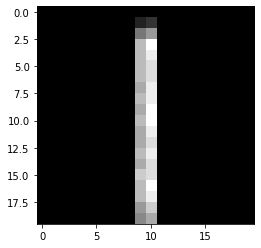

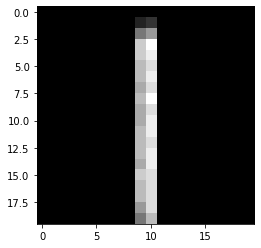

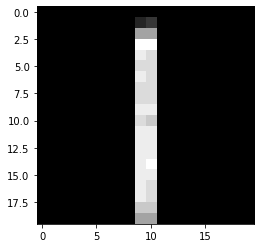

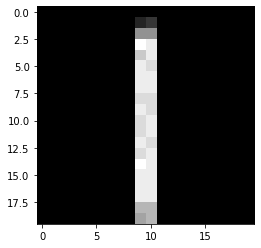

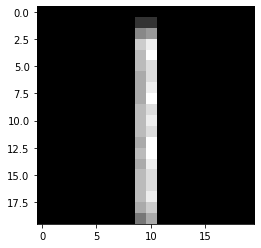

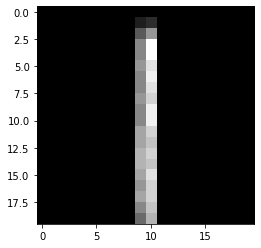

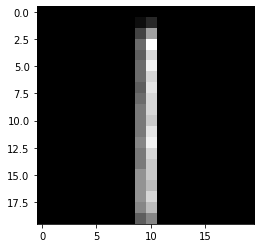

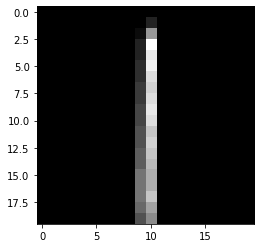

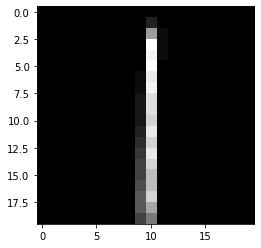

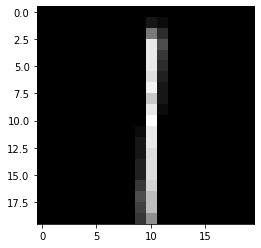

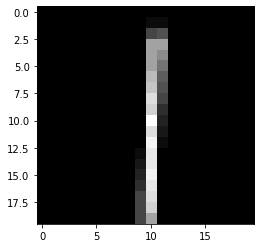

Episode not successful!


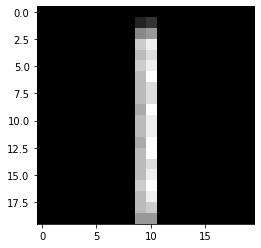

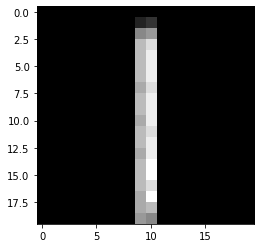

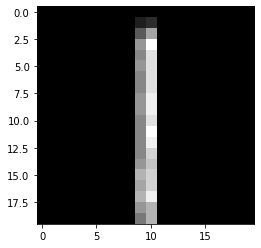

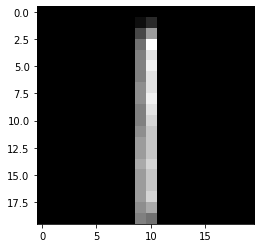

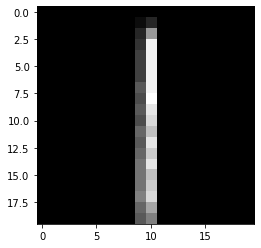

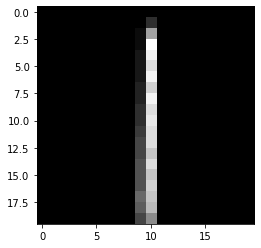

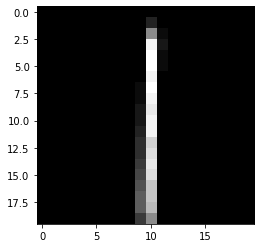

KeyboardInterrupt: ignored

In [16]:
manual_seed(SEED)

if WANDB:
    wandb.init(project='BioLCNet', entity='singularbrain', config=network_hparams)
net = LCNet(time,**network_hparams, reward_fn=RLTasks('CartPole-v0'), wandb_active = WANDB)
net.learn(**network_hparams)

# Gym Playground

In [ ]:
env = gym.make('CartPole-v0')
env.reset()
intensity = 128.0
screen = env.render(mode='rgb_array')
screen = screen.transpose((2, 0, 1))
_, screen_height, screen_width = screen.shape
screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
view_width = int(screen_width * 0.6)
world_width = env.x_threshold * 2
scale = screen_width / world_width
cart_location = int(env.state[0] * scale + screen_width / 2.0)
if cart_location < view_width // 2:
    slice_range = slice(view_width)
elif cart_location > (screen_width - view_width // 2):
    slice_range = slice(-view_width, None)
else:
    slice_range = slice(cart_location - view_width // 2,
                        cart_location + view_width // 2)
# Strip off the edges, so that we have a square image centered on a cart
screen = screen[:, :, slice_range]
# Convert to float, rescale, convert to torch tensor
crop_size = 20
screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
screen = torch.from_numpy(screen)
resize = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize([crop_size, crop_size], interpolation=Image.CUBIC),
            transforms.Lambda(lambda x: crop(x, 0, 0, crop_size*0.75, crop_size)),
            transforms.Resize([crop_size, crop_size], interpolation=Image.CUBIC),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: -1.0*x +1.0),
            # transforms.Lambda(lambda x: 1.0 if x<1.0 else 0.0),
            # transforms.Lambda(lambda x: 0*x[x<1.0]),
            transforms.Lambda(lambda x: x * intensity),
            transforms.Lambda(lambda x: PoissonEncoder(time=255, dt=1)(x))])
device = 'cuda'

# Resize, and add a batch dimension (BCHW)
screen = resize(screen)
# print(screen.shape)

print(screen.shape)
# screen = screen.to(device)
# plt.imshow(screen.cpu().permute(
#         1, 2, 0).numpy().squeeze(), cmap='gray')

# print(a.shape)
a = screen.sum(axis=0)

a = a.to(device)
plt.imshow(a.cpu().numpy().squeeze(), cmap='gray')
obs, reward, done, info = env.step(1)
obs, reward, done, info 

# BindsNet Breakout

In [ ]:
! pip install git+https://github.com/BindsNET/bindsnet.git


  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-mtcdoh5t
  Running command git clone -q https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-mtcdoh5t
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.5 MB 55.4 MB/s 
     |████████████████████████████████| 11.3 MB 64.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 120 kB 79.5 MB/s 
     |████████████████████████████████| 73 kB 2.6 MB/s 
     |████████████████████████████████| 60.4 MB 1.2 MB/s 
     |████████████████████████████████| 1.7 MB 66.4 MB/s 
     |████████████████████████████████| 11.2 MB 96.6 MB/s 
     |████████████████████████████████| 180 kB 51.1 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-01-16 14:47:08--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   486KB/s    in 23s     

2022-01-16 14:47:32 (469 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin fr

In [ ]:
! pip install matplotlib==2.1.1

### Restart your runtime after this

     |████████████████████████████████| 36.1 MB 1.3 MB/s 
  Created wheel for matplotlib: filename=matplotlib-2.1.1-cp37-cp37m-linux_x86_64.whl size=10243757 sha256=18b68a6b31696664021b1bb9df2061292918bfcc3217241b860d9366de83d8c8
  Stored in directory: /root/.cache/pip/wheels/f3/7a/d6/021782cff10d8257e030d4a766ca5ed9667fd8758606fbbeff
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
seaborn 0.11.2 requires matplotlib>=2.2, but you have matplotlib 2.1.1 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.1.1 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.1.1 which is incompatible.
bindsn

In [ ]:
### gym and colab compatibility

!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
%matplotlib inline

In [ ]:
from bindsnet.encoding import bernoulli
from bindsnet.environment import GymEnvironment
from bindsnet.learning import MSTDP
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.pipeline import EnvironmentPipeline
from bindsnet.pipeline.action import select_softmax
import time

# Build network.
network = Network(dt=1.0)

# Layers of neurons.
inpt = Input(n=80 * 80, shape=[1, 1, 1, 80, 80], traces=True)
middle = LIFNodes(n=100, traces=True)
out = LIFNodes(n=4, refrac=0, traces=True)

# Connections between layers.
inpt_middle = Connection(source=inpt, target=middle, wmin=0, wmax=1e-1)
middle_out = Connection(
    source=middle,
    target=out,
    wmin=0,
    wmax=1,
    update_rule=MSTDP,
    nu=1e-1,
    norm=0.5 * middle.n,
)

# Add all layers and connections to the network.
network.add_layer(inpt, name="Input Layer")
network.add_layer(middle, name="Hidden Layer")
network.add_layer(out, name="Output Layer")
network.add_connection(inpt_middle, source="Input Layer", target="Hidden Layer")
network.add_connection(middle_out, source="Hidden Layer", target="Output Layer")

# Load the Breakout environment.
environment = GymEnvironment("BreakoutDeterministic-v4")
environment.reset()

# Build pipeline from specified components.
environment_pipeline = EnvironmentPipeline(
    network,
    environment,
    encoding=bernoulli,
    action_function=select_softmax,
    output="Output Layer",
    time=100,
    history_length=1,
    delta=1,
    plot_interval=None,
    render_interval=None,
)




def run_pipeline(pipeline, episode_count):
    for i in range(episode_count):
        total_reward = 0
        pipeline.reset_state_variables()
        is_done = False
        render_counter = 0
        while not is_done:
            # if render_counter % 10 == 0:
            #     # plt.title("Game image")
            #     # plt.imshow(pipeline.env.render())
            #     # plt.show()
            #     a = pipeline.env.render()
            #     print(a)
            #     time.sleep(0.1)
                
            render_counter += 1
            result = pipeline.env_step()
            pipeline.step(result)

            reward = result[1]
            total_reward += reward
            
            is_done = result[2]
        print(f"Episode {i} total reward:{total_reward}")
    pipeline.env.close()

print("Training: ")
run_pipeline(environment_pipeline, episode_count=100)

# stop MSTDP
environment_pipeline.network.learning = False

print("Testing: ")
run_pipeline(environment_pipeline, episode_count=100)

Training: 
Episode 0 total reward:2.0
Episode 1 total reward:0.0
Episode 2 total reward:0.0
Episode 3 total reward:1.0
Episode 4 total reward:1.0
Episode 5 total reward:1.0
Episode 6 total reward:1.0
Episode 7 total reward:3.0
Episode 8 total reward:1.0
Episode 9 total reward:2.0
Episode 10 total reward:2.0
Episode 11 total reward:2.0
Episode 12 total reward:0.0
Episode 13 total reward:1.0
Episode 14 total reward:0.0
Episode 15 total reward:2.0
Episode 16 total reward:0.0
Episode 17 total reward:0.0
Episode 18 total reward:2.0
Episode 19 total reward:0.0
Episode 20 total reward:2.0
Episode 21 total reward:0.0
Episode 22 total reward:0.0
Episode 23 total reward:0.0
Episode 24 total reward:0.0
Episode 25 total reward:1.0
Episode 26 total reward:1.0
Episode 27 total reward:1.0
Episode 28 total reward:1.0
Episode 29 total reward:0.0
Episode 30 total reward:2.0
Episode 31 total reward:3.0
Episode 32 total reward:2.0
Episode 33 total reward:0.0
Episode 34 total reward:2.0
Episode 35 total re

KeyboardInterrupt: ignored